In [1]:
# Movement detection

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


import glob 

import statistics

from statistics import StatisticsError

In [3]:
#To make things easier to run on this document, I renamed the directories.

files_movement = list(glob.glob("movement_test_data/*.csv"))
files_movement.sort()



In [5]:
# Keeping the last file as a test dataset

test_file_movement = files_movement[-1]
files_movement.pop(-1)

df_movement = pd.DataFrame()

for file in files_movement:
    df_open = pd.read_csv(file, header=None)
    df_movement = pd.concat([df_movement, df_open], axis=0)
    del df_open
    
df_movement = df_movement.reset_index(drop=True)



In [ ]:
###### Renaming the variable to 'obs'

In [ ]:
df_movement.columns = ['obs']

In [6]:
####### Each second is made up of 250 observations

In [7]:
obs_per_sec = round(df_movement.shape[0]/(4*4*60))


In [19]:
# Calculating the basic metrics

print(df_movement.describe())

                 obs
count  239975.000000
mean       51.449868
std        14.734650
min         0.000000
25%        47.000000
50%        53.000000
75%        59.000000
max        77.000000


In [ ]:
mean = df_movement.obs.mean()
print("Mean: {}".format(mean))

median = df_movement.obs.median()
print("Median: {}".format(median))

In [9]:
####### Visualising the dataset at two cases to see if there are any unique patterns.

###### I did this visual inspection for a few more slices in Spyder, which I didn't add here. Only showing two. 

####### First we look at a slice where there is movement

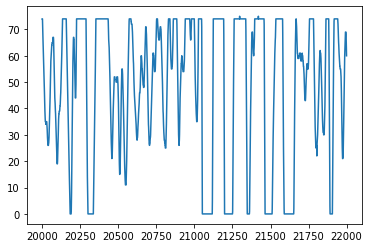

In [15]:
plt.plot(df_movement.iloc[20000:22000])

In [ ]:
####### Now we look at one where there is no movement

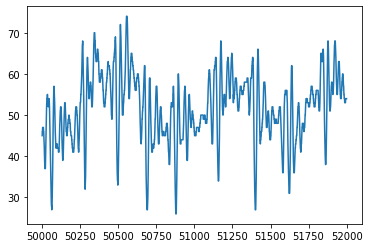

In [14]:
plt.plot(df_movement.iloc[50000:52000])

###### Notes - 

1. Where there is movement, the amplitude of the observations reaches both the upper and lower extremes on a regular basis. The peaks hit 70 and the troughs go all the way to 0. 

2. In the case of movement, the amplitudes tend to 'stick' to an extreme value for a few observations, which can possibly be used as an signal for movement.

3. When not moving, the data appears more noisy (and even sinusoidal in a way). The peaks max out to 70, but the troughs usually do not reach 0. 

In [ ]:
###### Trying to generate some features we could possibly use - The idea is to see if any of the below is a signal for movement

In [22]:
# The deviation from the global mean and the individual observation
df_movement['diff_mean'] = mean - df_movement['obs']

# The rate of change of the deviation from mean w.r.t the mean
df_movement['delta_mean'] = abs(df_movement['diff_mean'] / mean)

#Rolling mean of delta_mean for 100 milliseconds window
df_movement['delta_mean_rolling_100ms'] = df_movement['delta_mean'].rolling(window=obs_per_sec//10).mean()

#Rolling mean of delta_mean for 200 milliseconds window
df_movement['delta_mean_rolling_200ms'] = df_movement['delta_mean'].rolling(window=obs_per_sec//5).mean()

# Absolute differencing of observations by 1 value behind (to see if the time series can be made stationary)
df_movement['diff_1'] = abs(df_movement['obs'].diff(1))

# Rolling mean of diff_1 for 10 observations
df_movement['diff_1_rolling_mean_abs'] = df_movement['diff_1'].rolling(window=10).mean()

# Absolute differencing of the previous value by 1
df_movement['diff_2'] = abs(df_movement['diff_1_rolling_mean_abs'].diff())

In [23]:
###### After much experimentation, I found out that values for 'delta_mean_rolling_200ms' begin to spike when movement begins and go down when movement stops.

###### The spike happens with a lag of 200 milliseconds (50 observations), since this is a rolling statistic. 

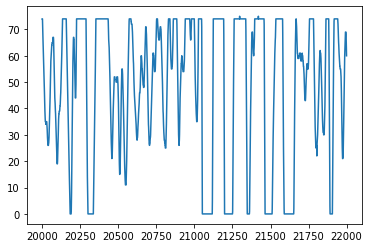

In [30]:
plt.plot(df_movement.iloc[20000:22000].obs)


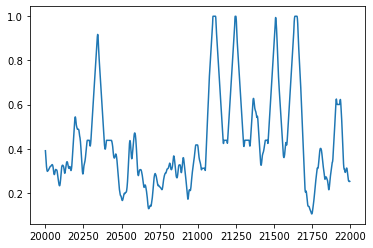

In [31]:
plt.plot(df_movement.iloc[20000:22000].delta_mean_rolling_200ms)

###### After looking at the data at many intervals, I set 'delta_mean_rolling_200ms' > 0.2 as the threshold for classifying an observation as belonging to movement.

In [ ]:
####### Here, I construct a filter which assigns 1 for movement and 0 otherwise over a window of 200 milliseconds (50 observations)

In [ ]:
df_movement['movement'] = 0

for index, row in df_movement.iterrows():

    df_movement.loc[index-49:index+1, 'movement'] = np.where(
            
            (df_movement.iloc[index]['delta_mean_ma_200ms'] > 0.2) & (~np.isnan(df_movement.iloc[index]['delta_mean_ma_200ms']))
            , 1, 0)

    
df_movement.loc[(np.isnan(df_movement['delta_mean_ma_200ms'])), 'delta_mean_ma_200ms'] = 0


In [ ]:
# Now using this filter on test data

In [ ]:
df_movement_test = pd.read_csv(test_file_movement, header=None, names=['obs'])


In [32]:
df_movement_test['diff_mean'] = mean - df_movement_test['obs']

df_movement_test['delta_mean'] = abs(df_movement_test['diff_mean'] / mean)

df_movement_test['delta_mean_rolling_100ms'] = df_movement_test['delta_mean'].rolling(window=obs_per_sec//10).mean()

df_movement_test['delta_mean_rolling_200ms'] = df_movement_test['delta_mean'].rolling(window=obs_per_sec//5).mean()


NameError: name 'df_movement_test' is not defined

In [ ]:
df_movement_test['movement'] = 0

for index, row in df_movement_test.iterrows():

    df_movement_test.loc[index-49:index+1, 'movement'] = np.where(
            
            (df_movement_test.iloc[index]['delta_mean_ma_200ms'] > 0.2) & (~np.isnan(df_movement_test.iloc[index]['delta_mean_ma_200ms']))
            , 1, 0)

    
df_movement_test.loc[(np.isnan(df_movement_test['delta_mean_ma_200ms'])), 'delta_mean_ma_200ms'] = 0


In [ ]:
movement_detected = pd.Series()

for sec in range(0, df_movement_test.shape[0], obs_per_sec):
    try:
        verdict = bool(np.where(statistics.mode(df_movement_test.iloc[sec:sec+obs_per_sec]['movement']) == 1, True, False))
    except StatisticsError:
        verdict = True
        
    movement_detected[str(sec)+":"+str(sec+obs_per_sec)] = verdict